<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
<center>Author: [Mariya Mansurova](https://www.linkedin.com/in/mariya-mansurova-04070982/), analyst & developer in Yandex.Metrics team. <br>Translated by [Ivan Zakharov](https://www.linkedin.com/in/ivan-zakharov/), ML enthusiast.
<br>All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #9 (demo)
## <center> Time series analysis

**Fill cells marked with "Your code here" and submit your answers to the questions through the [web form](https://docs.google.com/forms/d/1UYQ_WYSpsV3VSlZAzhSN_YXmyjV7YlTP8EYMg8M8SoM/edit).**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

3.4.1


## Data preparation

In [2]:
df = pd.read_csv('../input/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

## Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


**<font color='red'>Question 1:</font>** What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

- 4947
- 3426
- 5229
- 2744

In [8]:
# You code here
dff = df.copy()
df_train = dff[:-predictions]

p = Prophet()
p.fit(df_train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = p.make_future_dataframe(periods=predictions)
future.tail(n=3)


,ds
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [10]:
forecast = p.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
380,2016-01-18,2990.135281,2873.866992,3708.113884,2966.450005,3012.926043,281.357669,281.357669,281.357669,281.357669,281.357669,281.357669,0.0,0.0,0.0,3271.492950
381,2016-01-19,2995.542971,3135.988130,3951.104215,2970.588212,3019.690978,541.423837,541.423837,541.423837,541.423837,541.423837,541.423837,0.0,0.0,0.0,3536.966808
382,2016-01-20,3000.950660,2983.752584,3830.583799,2974.583870,3026.624736,425.547911,425.547911,425.547911,425.547911,425.547911,425.547911,0.0,0.0,0.0,3426.498570


Estimate the quality of the prediction with the last 30 points.

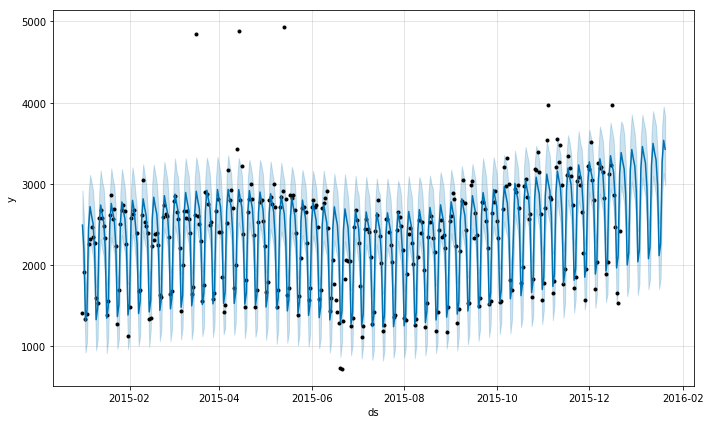

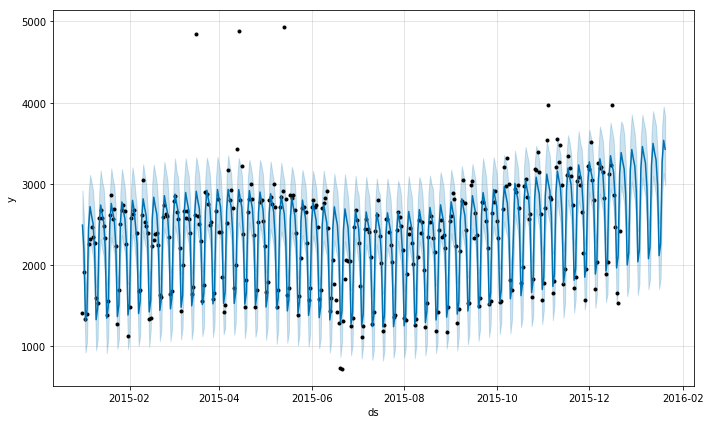

In [11]:
# You code here
p.plot(forecast)

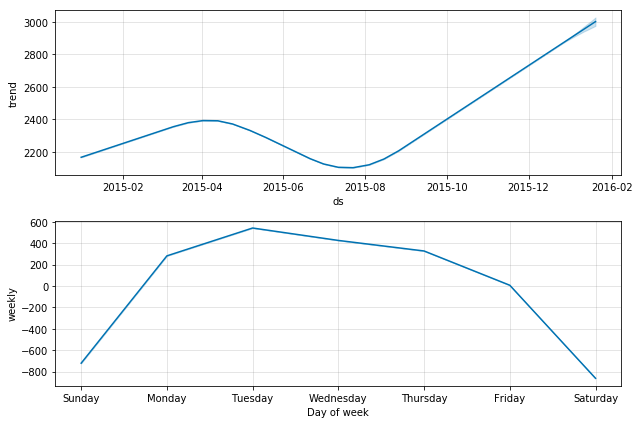

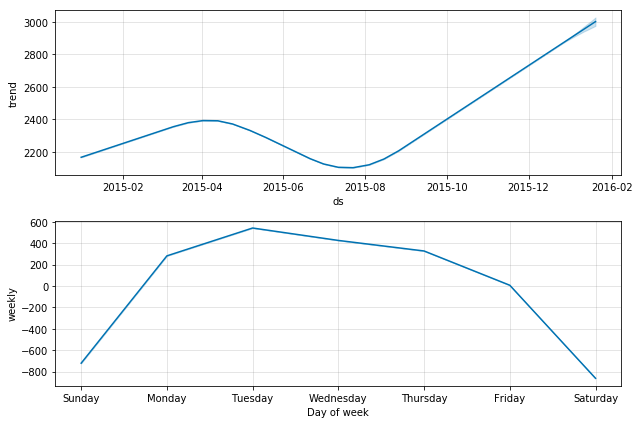

In [12]:
p.plot_components(forecast)

In [13]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [14]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [15]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2016-01-18,3271.492950,2873.866992,3708.113884,2983
2016-01-19,3536.966808,3135.988130,3951.104215,3389
2016-01-20,3426.498570,2983.752584,3830.583799,3559


In [16]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [17]:
for err_name, err_value in calculate_forecast_errors(cmp_df, predictions).items():
    print(err_name, err_value)

MAPE 34.502925740494526
MAE 599.8383194732162


**<font color='red'>Question 2:</font> What is MAPE equal to?**

- 34.5
- 42.42
- 5.39
- 65.91

**<font color='red'>Question 3:</font> What is MAE equal to?**

- 355
- 4007
- 600
- 903

## Predicting with ARIMA

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

**<font color='red'>Question 4:</font> Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?**

- Series is stationary, p_value = 0.107
- Series is not stationary, p_value = 0.107
- Series is stationary, p_value = 0.001
- Series is not stationary, p_value = 0.001

In [21]:
# You code here
y = pd.Series(df_train['y'])
p_value = sm.tsa.stattools.adfuller(y)[1]
print(p_value)

0.1073921962761209


**Next, we turn to the construction of the SARIMAX model (`sm.tsa.statespace.SARIMAX`).<br> <font color='red'>Question 5:</font> What parameters are the best for the model according to the `AIC` criterion?**

- D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
- D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

In [ ]:
# You code here